## pyroomacoustics demo

在本脚本中，我们展示了一些有关`pyroomacoustics`的一些特性：

- （1）相关python类变成与方便的面向对象接口。
- （2）房间脉冲响应生成器（RIR，Room Impulse Response）。
- （3）相关算法设计

本脚本的演示示例列表：
- 1、创建一个2D/3D房间
- 2、添加声源和麦克风
- 3、RIR生成以及传播仿真（propagation simulation）
- 4、波束形成（Beamforming）
- 5、波达方向（Direction-of-Arrival）
- 6、自适应滤波（Adaptive filtering）
- 7、短时傅利叶转换（STFT）处理
- 8、源分离（Source Separation）

更多内容可以参考[Pyroomacoustics的Github仓库](https://github.com/LCAV/pyroomacoustics)或者参考[论文](https://arxiv.org/pdf/1710.04196.pdf)，引用格式如下所示：

R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018.

In [173]:
# 倒入必要的软件包
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import IPython
import pyroomacoustics as pra

### 一、创建2D/3D房间

**注意：**
- 在定义房间的2D空间节点时候，需要<font color="red">注意其顺序</font>，否则不会出现预期的房间形状。
- <font color="red">在构建节点时候需要逆时针方向一次定义节点坐标</font>。

[[0 0 5 5 3 3]
 [0 3 3 1 1 0]]


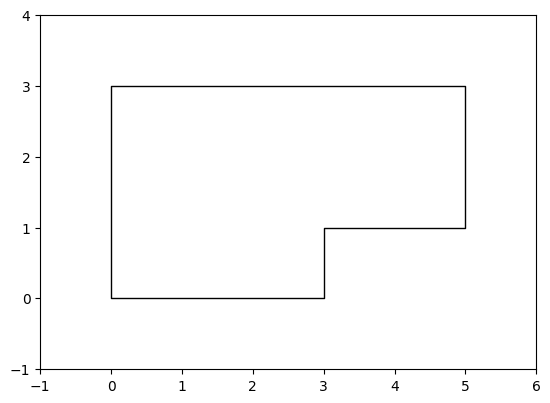

In [174]:
# 定义房间的二维空间节点（顺时针旋转）
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T
print(corners)

# 由二维空间节点构造2D房间
room = pra.Room.from_corners(corners)
# print(type(room))   # 查看room的数据类型

# 绘制2的房间
fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

如果想要构建3D房间，我们可以将构建的2D房间拉伸一个特定的长度。

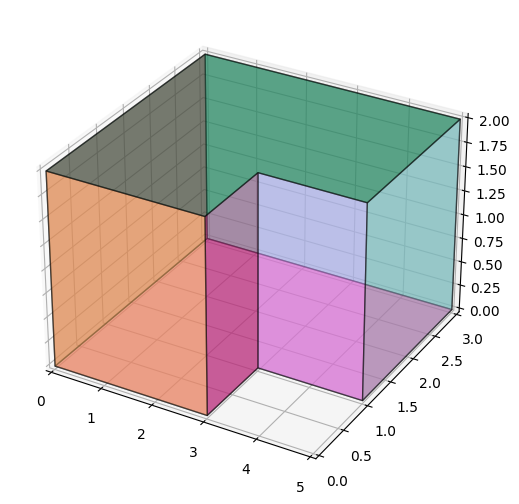

In [175]:
room.extrude(2.)

fig, ax = room.plot()

### 二、添加声源与麦克风

我们可以很方便的通过`add_source`方法给创建的房间模型添加声源。

✨ 另外，我们还可以将`numpy`数组作为声源信号。**说明**：后续使用自己构建的声源数据的时候会用到这个方法。

本脚本使用的音频数据源来自于：[Festvox: US bdl (US male)](http://www.festvox.org/cmu_arctic/dbs_bdl.html)

<class 'int'>
<class 'numpy.ndarray'>


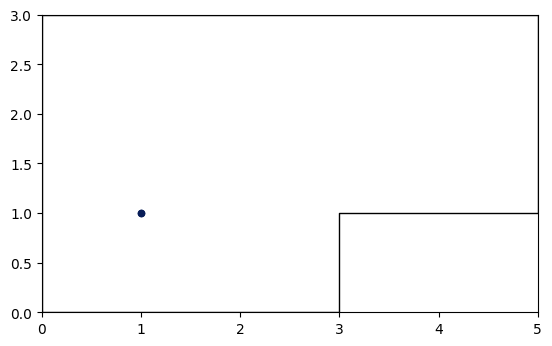

In [176]:
# 使用wavfile.read方法读取arctic_10001.wav音频数据，返回频率fs和信号signal数据
# fs的数据类型为整型int；
# signal的数据类型为numpy.ndarray
fs, signal = wavfile.read("arctic_a0001.wav")
print(type(fs))
print(type(signal))

# 向房间中添加信号源
# 首通过from_corners()方法设置房间的频率属性、ray_tracing、空气吸收率（air_absorption）进行设置，并生成新的2D房间room对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
# 使用add_source()方法在[1., 1.]位置添加信号源signal
room.add_source([1.,1.], signal=signal)

# 绘制房间和信号源
fig, ax = room.plot()

同样的，我们可以添加麦克风阵列。

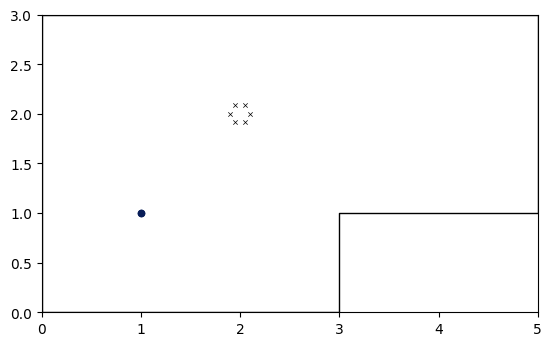

In [177]:
# 圆形麦克风阵列的构建方法：使用circular_2D_array()方法在圆心位置为[2.,2.]的地方构建一个半径radius为0.1，麦克风个数M为6的麦克风圆形阵列。
R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
# 添加麦克风阵列的方法：首先使用MicrophoneArray()类方法构建一个麦克风阵列对象；然后使用add_microphone_array()将构建的麦克风阵列添加到room对象中
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

# 绘制房间与麦克风矩阵
fig, ax = room.plot()

### 三、房间脉冲响应（RIR）生成器与传播仿真

使用ISM（Image Source Model）计算每个麦克风的脉冲响应。通过房间构造器（Room Constructor），我们可以设置ISM的最大ISM阶数和吸收率。

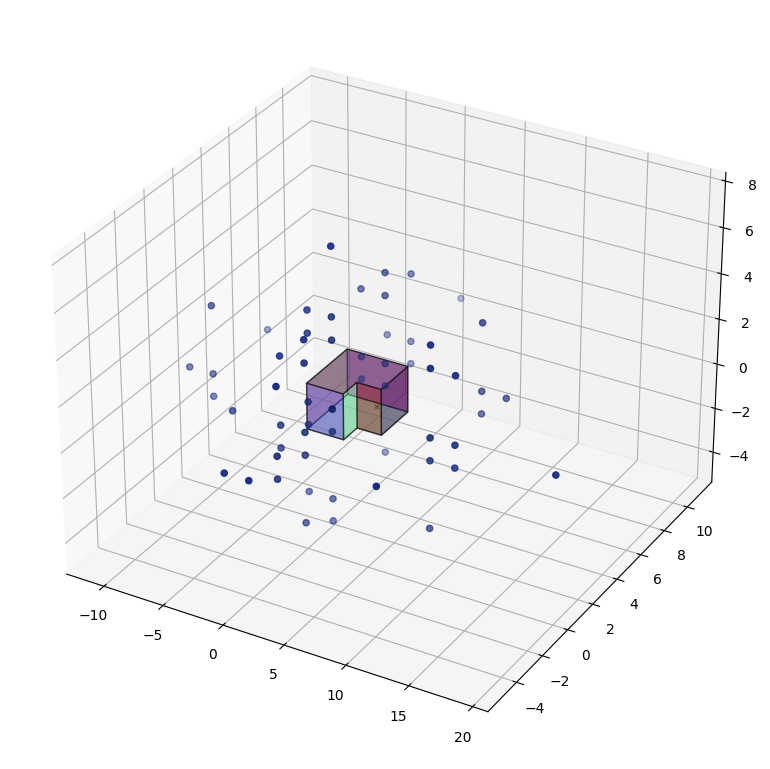

In [178]:
# 指定信号源
# fs, signal = wavfile.read("arctic_a0001.wav")
fs, signal = wavfile.read("google_speech_commands/two/0a7c2a8d_nohash_0.wav")

# 设置房间脉冲响应ISM方法的最大阶数max_order，并设置响应的频率、materials、ray_tracing、空气吸收率参数，并实例化一个带有RIR以及相关参数的房间对象
room = pra.Room.from_corners(corners, fs=fs, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
# 使用extrude()方法构建3D房间
room.extrude(2., materials=pra.Material(0.2, 0.15))

# 设置ray tracing参数：接收半径（receiver_radius）、n_rays、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 添加信号源
room.add_source([1., 1., 0.5], signal=signal)

# 添加两个麦克风阵列
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])
room.add_microphone(R)

# 使用image_source_model()类方法计算房间room的麦克风脉冲响应
room.image_source_model()

# 对3D多面体房间和image source进行可视化处理
fig, ax = room.plot(img_order=3)
fig.set_size_inches(10.5, 7.5)

当计算了房间的image sources之后，我们就可以是使用room的plot_rir()类方法绘制麦克风（房间脉冲响应）RIR了。

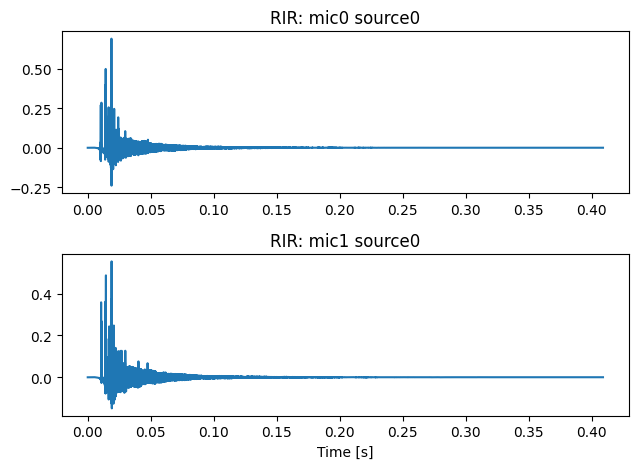

In [179]:
room.plot_rir()
fig = plt.gcf()
# fig.set_size_inches(20, 10)

🌠 <font color="red">**注意：**</font>

其实，用好`pyroomacoutics`软件包的一个关键点在于：<font color="red">**很好的理解每个方法输出数据的结构。**</font>

比如，上面在使用ISM（Image Source Model）计算两个个麦克风的脉冲响应后，代码如下所示：

```python
# 添加两个麦克风阵列
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])
room.add_microphone(R)

# 使用image_source_model()类方法计算房间room的麦克风脉冲响应
room.image_source_model()
```

此时在房间对象`room`中就有了`rir`类变量，他存储了`room`对象的房间脉冲响应（RIR）结果，需要注意以下几点：

- （1）两个麦克风的房间脉冲是以列表形式存储的，可以通过代码`type(room.rir)`查看其数据类型；
- （2）`room.rir`共包括两个子元素，分别存放两个麦克风的RIR结果，可以通过`len(room.rir)`查看；
- （3）`room.rir`列表的两个元素是以`numpy.ndarray`数据格式存储的，可以通过`type(room.rir[0][0])`和`type(room.rir[1][0])`分别查看。且数据长度均为6545，可以通过`len(room.rir[0][0])`与`len(room.rir[1][0])`分别查看。

In [180]:
# 查看room.rir的数据类型
print("1、麦克风的房间脉冲room.rir的数据存储存储：", type(room.rir))
print("2、麦克风的房间脉冲room.rir包含两个麦克风RIR结果：", len(room.rir))
print("3、room.rir包含的两个RIR结果的数据类型：", type(room.rir[0][0]))
print("4、RIR结果的长度为：", len(room.rir[0][0]))

1、麦克风的房间脉冲room.rir的数据存储存储： <class 'list'>
2、麦克风的房间脉冲room.rir包含两个麦克风RIR结果： 2
3、room.rir包含的两个RIR结果的数据类型： <class 'numpy.ndarray'>
4、RIR结果的长度为： 6545


我们还可以使用`measure_rt60()`方法计算RIR的混响时间（reverberation time）。

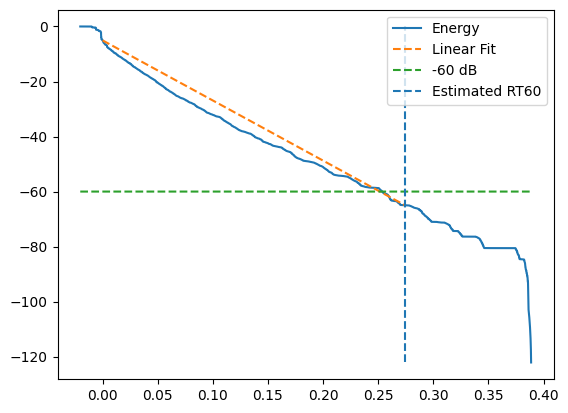

The RT60 is 274 ms


In [181]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

另外，我们可以通过与上面这些脉冲响应进行卷积操作，仿真我们的信号：

In [182]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 22544)


In [183]:
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

# signal.shape

Original WAV:


In [184]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


### 四、波束成型（Beamforming）

Reference implementations of beamforming are also provided. Fixed weight beamforming is possible in both the time and frequency domain. Classic beamforming algorithms are included as special cases of the acoustic rake receivers, namely by including only the direct source we obtain DAS and MVDR beamformers.

下面是波束成型的实现代码。固定权重波束成型在时域和频域都是可能的。经典的波束成形算法属于 acoustic rake receivers 一种特例，即仅包括 direct source，我们获得两个波束成型器：

- `DAS`
- `MVDR`

In [185]:
fs

16000

/tmp/ipykernel_6358/2943492396.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_noise, noise = wavfile.read("google_speech_commands/_background_noise_/exercise_bike.wav")


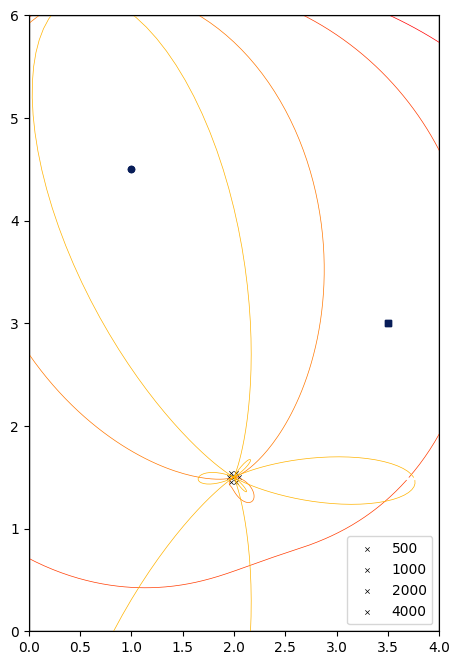

In [225]:
Lg_t = 0.100                # 滤波尺寸（秒）
Lg = np.ceil(Lg_t * fs)     # in samples

# 设定信号和噪声源头
fs_signal, signal = wavfile.read("arctic_a0001.wav")
fs_noise, noise = wavfile.read("google_speech_commands/_background_noise_/exercise_bike.wav")

# print("信号的采样频率:", fs_signal)
# print("噪声的采样频率:", fs_noise)

# 构造一个包括声音和噪声的 4x6 shoebox 房间同时进行仿真
room_bf = pra.ShoeBox([4, 6], fs=fs, max_order=12)
# room_bf.extrude(1.)

# 声音源和噪声的位置
source_loc = np.array([1, 4.5])
interferer_loc = np.array([3.5, 3.])

# 添加声音 source 源和噪声 interferer，并保持添加信号的长度保持一致
# 另外，下面两条指令分别将signal信号添加room_bf.sources[0]中；
# 将noise信号添加到room_bf.sources[1]中
room_bf.add_source(source_loc, delay=0, signal=signal)
room_bf.add_source(interferer_loc, delay=0., signal=noise[:len(signal)])

# 创造 Amazon Echo 的几何等效？（Create geometry equivalent to Amazon Echo）
# center = [2, 1.5, 0.3]  # 单位为m
center = [2, 1.5]   # 单位为m
radius = 50e-3      # 阵列的半径3.75cm

fft_len = 512       # 傅立叶变换长度

# 设置回声阵列
echo = pra.circular_2D_array(center=center, M=6, phi0=0, radius=radius)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)

# 添加麦克风波束
mics = pra.Beamformer(echo, room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# # 计算 DAS 权重
mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])

# 在仿真前，绘制房间和波束成型的结果
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])

# ax.set_xlim([-1, 5])
# ax.set_ylim([-1, 7])

fig.set_size_inches(20, 8)

In [187]:
print(type(room_bf))

print(type(mics))

print(type(room_bf.sources))
print(type(room_bf.sources[0]))

<class 'pyroomacoustics.room.ShoeBox'>
<class 'pyroomacoustics.beamforming.Beamformer'>
<class 'list'>
<class 'pyroomacoustics.soundsource.SoundSource'>


为了理解上面的代码，首先，需要对如下三个对象的数据结构有一定的理解：

- `room_bf`：`pyroomacoustics.room.ShoeBox`的数据类型、类属性和类方法。
- `room_bf.sources`及其`room_bf.sources[x]`的数据类型、数据内容
- `mics`：`pyroomacoustics.beamforming.Beamformer`的数据类型、类属性和类方法

在Python中，查看一个对象的所有属性名和方法名的函数包括`dir()`和`__dir__()`两个方法，两个方法都会返回某个对象所包含的所有属性名和方法名的列表。其中，两者的不同主要体现在：

- `dir()`方法返回的是有序列表（以首字母为序）
- `__dir__()`方法返回的是无序列表

**`room_bf`的数据结构：**

In [188]:
# 首先看一下__dir__()方法返回的数据类型
print("一个对象的__dir__的数据类型为列表类型：", type(room_bf.__dir__()))

# 查看room_bf的数据类型
print("\nroom_bf的数据类型为：\n", type(room_bf))

# 使用__dir__()方法查看room_bf的所有属性名和方法名
print("\nroom_bf对象的所有属性名和方法名：\n", dir(room_bf))

一个对象的__dir__的数据类型为列表类型： <class 'list'>

room_bf的数据类型为：
 <class 'pyroomacoustics.room.ShoeBox'>

room_bf对象的所有属性名和方法名：
 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_init_room_engine', '_set_ray_tracing_options', '_update_room_engine_params', '_var_init', '_wall_mapping', 'add', 'add_microphone', 'add_microphone_array', 'add_soundsource', 'add_source', 'air_absorption', 'c', 'compute_rir', 'dim', 'direct_snr', 'extrude', 'from_corners', 'fs', 'get_bbox', 'get_volume', 'get_wall_by_name', 'image_source_model', 'is_inside', 'is_multi_band', 'max_order', 'measure_rt60', 'mic_array', 'n_mics', 'n_sources', 'octave_bands', 'physics', 'plot', 'plot_rir', 'ray_tracing', 'rir', 'room_engine', 'rt60_t

**`room_bf.sources`的数据结构：**

In [189]:
# 查看room_bf.sources的数据内容。其为列表，这里使用for循环逐个输出列表中的内容
for item in room_bf.sources:
    print("\nroom_bf.sources中的内容为：\n", item)

# 查看room_bf.sources[0]的数据类型及其所有类属性和类方法
print("\nroom_bf.sources[0]的数据结构：\n", type(room_bf.sources[0]))
print("\nroom_bf.sources[0]的所有类属性和类方法：\n", dir(room_bf.sources[0]))

# 使用room_bf.sources[0]的类属性signal可以获得添加ndarray格式的声源数据
print("\nroom_bf.sources[0].signal的数据结构为：\n", type(room_bf.sources[0].signal))
print("\nroom_bf.sources[0].signal的数据内容为：\n", room_bf.sources[0].signal)


room_bf.sources中的内容为：

room_bf.sources中的内容为：

room_bf.sources[0]的数据结构：
 <class 'pyroomacoustics.soundsource.SoundSource'>

room_bf.sources[0]的所有类属性和类方法：
 ['I', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_signal', 'damping', 'delay', 'dim', 'directivity', 'distance', 'generators', 'get_damping', 'get_images', 'get_rir', 'images', 'max_order', 'ordering', 'orders', 'position', 'set_directivity', 'set_ordering', 'signal', 'wall_sequence', 'walls']

room_bf.sources[0].signal的数据结构为：
 <class 'numpy.ndarray'>

room_bf.sources[0].signal的数据内容为：
 [ -38  -15  -19 ... -128 -144 -148]


**`mics`的数据结构：**

In [195]:
# 查看mics的数据类型及其类属性、类方法
print("mics的数据类型为：\n", type(mics))
print("\nmics的类属性和类方法为：\n", dir(mics))

# 通过mics的signal类属性查看mics的信号类型及其形状
print("\nmics包含信号的数据类型为：\n", type(mics.signals))
print("\nmics信号的数据形状\n", mics.signals.shape)

mics的数据类型为：
 <class 'pyroomacoustics.beamforming.Beamformer'>

mics的类属性和类方法为：
 ['L', 'Lg', 'M', 'N', 'R', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'append', 'center', 'dim', 'directivity', 'far_field_weights', 'filters', 'filters_from_weights', 'frequencies', 'fs', 'hop', 'nmic', 'plot', 'plot_beam_response', 'plot_response_from_point', 'process', 'rake_delay_and_sum_weights', 'rake_distortionless_filters', 'rake_max_sinr_filters', 'rake_max_sinr_weights', 'rake_max_udr_filters', 'rake_max_udr_weights', 'rake_mvdr_filters', 'rake_one_forcing_filters', 'rake_one_forcing_weights', 'rake_perceptual_filters', 'record', 'response', 'response_from_point', 'set_directivity'

下面对麦克风中心进行传播仿真与监听

In [196]:
room_bf.compute_rir()
room_bf.simulate()
print("Center Mic:")
IPython.display.Audio(room_bf.mic_array.signals[-1,:], rate=fs)

Center Mic:


下面查看 DAS 波束成型方法是如何改善麦克风中心的音频效果的

In [198]:
signal_das = mics.process(FD=False)
print("DAS 波束成型的信号：")
IPython.display.Audio(signal_das, rate=fs)

DAS 波束成型的信号：


We can certainly hear that the noise at higher frequencies, where we have better directivity, is noticeable attenuated!

### 五、Direction of Arrival

Several reference algorithms for direction-of-arrival (DOA) estimation are provided. These methods work in the frequency domain of which there are generally two types: incoherent and coherent methods.

Pyroomacoustics库还提供了一些评估 DOA (Direction-of-arrival)的参考算法。如下所示，这些方法在频域领域中工作，通常有两种类型：非相干方法（incoherent methods）和相干方法（coherent methods）：

- `SRP-PHAT`
- `MUSIC`
- `WAVES`
- `TOPS`
- `FRIDA`

下面对两个信号源执行 DOA 计算

In [203]:
# 声源的位置，azimuth表示方向角，distance表示距离
azimuth = np.array([61., 270.]) / 180. * np.pi
distance = 2.       # 单位为m

A few constants and parameters for the algorithm such as the FFT size and the frequency range over which to perform DOA.

下面设置一些与 DOA 算法相关的常数和参数，比如 FFT 的大小、频率范围

In [240]:
c          = 343.           # 声速
fs         = 16000          # 采样频率
nfft       = 256            # FTT 尺寸
freq_range = [300, 3500]    # 频率范围

下面构建一个 2D 房间，并执行仿真

In [208]:
snr_db = 5.         # 信躁比
# sigma2用于赋值给pra.ShoeBox()方法的sigma2_awgn参数，用于给信号增加一个高斯随机噪声
sigma2 = 10 ** (-snr_db / 10) / (4. * np.pi * distance) ** 2

# 构建一个无回声的房间
room_dim = np.r_[10., 10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# print(dir(aroom))

As in the Beamforming example, we will use an array geometry equivalent to that of an Amazon Echo.

在波束形成示例中，我们将使用与亚马逊回声等效的阵列几何。

In [222]:
# 添加回声阵列
echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
# 增加回声阵列中心
echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)

# 根据echo制定的回声位置，添加麦克风阵列
aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

We'll create two synthetic signals and add them to the room at the specified locations with respect to the array.

下面创建两个合成信号，并将他们添加到房间中相对应与阵列的指定位置

In [227]:
# 添加1s长度的信号
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    source_signal = np.random.randn(duration_samples)
    aroom.add_source(source_location, signal=source_signal)

# 仿真
aroom.simulate()

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [244]:
X = pra.transform.stft.analysis(
    aroom.mic_array.signals.T,  # 7组麦克风阵列信号
    nfft,                       # FFT尺寸
    nfft // 2                   # shift size between frames
)

print(type(X))
print("返回的傅立叶变换结果形状(n_frames, n_frequencies, n_channel)为：", X.shape)

# 交换X的 n_frames 和 n_channel 的位置
X = X.transpose([2, 1, 0])

print("最终的傅立叶变换结果形状(n_channel, n_frequencies, n_frame)为：", X.shape)

<class 'numpy.ndarray'>
返回的傅立叶变换结果形状(n_frames, n_frequencies, n_channel)为： (127, 129, 7)
最终的傅立叶变换结果形状(n_channel, n_frequencies, n_frame)为： (7, 129, 127)


下面比较一些响应的 DOA 算法

In [ ]:
algo_names = ['SRP', 'MUSIC', 'FRIDA', 'TOPS']
